# Deployment: a trading strategy
> **Warning!** Please run `01_cleaning.ipynb` and `03_prediction.ipynb` first if you haven't already

In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions.constants import BM_NAME, STARTDATE, ENDDATE, N_THRESHOLD_BPS, DATA_DIR, EVAL_START_DATE, TEST_START_DATE  # noqa: F401

from functions.helper_fns import featurize_time_series,load_active_returns,evaluate_model_performance,get_X_and_y_values  # noqa: F401
import seaborn as sns

In [ ]:
chosen_period = "1w"
optimum_model_name = "Stacking"
eval_dataset_mode = False

predictions_path = f"{DATA_DIR}/{BM_NAME}_eval_predictions_{optimum_model_name}.csv" if eval_dataset_mode else f"{DATA_DIR}/{BM_NAME}_{chosen_period}_outperformance_predictions_{optimum_model_name}.csv"
predictions = pd.read_csv(predictions_path,parse_dates=["Date"])
predictions

,Unnamed: 0,Ticker,Date,ar_1w_t,ar_1w_t_minus_1,ar_1w_t_minus_2,ar_1w_t_minus_3,ar_1w_t_minus_4,ar_1w_t_minus_5,ar_1w_t_minus_6,ar_1w_t_minus_7,ar_1w_t_minus_8,ar_1w_t_minus_9,ar_1w_t_minus_10,ar_1w_t_minus_11,ar_1w_t_minus_12,outperform_1w_predicted,outperform_1w_probability
0,197,A UN,2019-01-07,0,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,-0.045478,-0.003645,-0.016929,0,0.425309
1,198,A UN,2019-01-14,1,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,-0.045478,-0.003645,0,0.498285
2,199,A UN,2019-01-21,1,0.045550,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,-0.045478,0,0.451527
3,200,A UN,2019-01-28,0,0.026896,0.045550,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,0,0.405006
4,201,A UN,2019-02-04,1,0.001540,0.026896,0.045550,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0,0.466968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104619,249894,ZTS UN,2022-11-28,0,0.057178,-0.100848,0.003538,-0.024902,-0.008028,-0.001618,-0.003573,0.030963,-0.030485,0.020191,0.018032,0.001653,1,0.546172
104620,249895,ZTS UN,2022-12-05,0,-0.010912,0.057178,-0.100848,0.003538,-0.024902,-0.008028,-0.001618,-0.003573,0.030963,-0.030485,0.020191,0.018032,0,0.419003
104621,249896,ZTS UN,2022-12-12,1,0.006229,-0.010912,0.057178,-0.100848,0.003538,-0.024902,-0.008028,-0.001618,-0.003573,0.030963,-0.030485,0.020191,0,0.493526
104622,249897,ZTS UN,2022-12-19,0,0.039307,0.006229,-0.010912,0.057178,-0.100848,0.003538,-0.024902,-0.008028,-0.001618,-0.003573,0.030963,-0.030485,0,0.497346


In [673]:
if eval_dataset_mode:
    predictions_test = predictions
else:
    predictions_train_and_eval = predictions[predictions.Date < TEST_START_DATE] #not spectacularly useful but good for debugging
    predictions_test = predictions[predictions.Date >= TEST_START_DATE]
    predictions_test
(predictions_test.head())

,Unnamed: 0,Ticker,Date,ar_1w_t,ar_1w_t_minus_1,ar_1w_t_minus_2,ar_1w_t_minus_3,ar_1w_t_minus_4,ar_1w_t_minus_5,ar_1w_t_minus_6,ar_1w_t_minus_7,ar_1w_t_minus_8,ar_1w_t_minus_9,ar_1w_t_minus_10,ar_1w_t_minus_11,ar_1w_t_minus_12,outperform_1w_predicted,outperform_1w_probability
0,197,A UN,2019-01-07,0,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,-0.045478,-0.003645,-0.016929,0,0.425309
1,198,A UN,2019-01-14,1,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,-0.045478,-0.003645,0,0.498285
2,199,A UN,2019-01-21,1,0.045550,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,-0.045478,0,0.451527
3,200,A UN,2019-01-28,0,0.026896,0.045550,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0.035691,0,0.405006
4,201,A UN,2019-02-04,1,0.001540,0.026896,0.045550,-0.014865,-0.003642,-0.008701,-0.002074,0.044512,0.012005,0.078920,-0.012782,0.009624,0,0.466968


### Load prices by ticker and by BM

In [674]:
# Load data
bm_index_prices_df_path = DATA_DIR + BM_NAME + "_BM_prices.csv"
bm_holdings_prices_df_path = DATA_DIR + BM_NAME + "_constituents_prices.csv"

def load_bm_index_df(path):
    df = pd.read_csv(path, skiprows=3)
    df = df.rename(columns={df.columns[0]: "Date"})
    df = df[2:]
    #ensure all cols except Date are numeric. Coerce nan if not
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df["Date"] = pd.to_datetime(df["Date"])
    return df

bm_index_prices_raw = load_bm_index_df(bm_index_prices_df_path)
bm_holdings_prices_raw = load_bm_index_df(bm_holdings_prices_df_path)

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/2162835386.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

In [675]:
def remove_BBG_suffixes(df):
    """
    Remove the suffixes " Equity" from the column names
    """
    df.columns = df.columns.str.replace(' Equity', '')
    # df.columns = df.columns.str.replace(' Index', '') #let's keep the SPX Index in for clarity
    return df

def melt_data(df):
    """
    Melt the dataframe to have a column for the date, a column for the ticker and a column for the price
    """
    df = df.melt(id_vars=["Date"], var_name="Ticker", value_name="Price")
    return df

def preprocess_and_clean_data(df):
    df = remove_BBG_suffixes(df)
    df = melt_data(df)
    return df

bm_index_prices = preprocess_and_clean_data(bm_index_prices_raw)
bm_holdings_prices = preprocess_and_clean_data(bm_holdings_prices_raw)

In [676]:
# pricing_date = predictions_test.Date.iloc[0]
portfolio_df_array = []
unique_dates = predictions_test.Date.unique()
for pricing_date in unique_dates:
    this_date_predictions = predictions_test[predictions_test.Date == pricing_date]
    outperform_prob_column = f"outperform_{chosen_period}_probability"
    # print("This date predictions df") 
    # print(this_date_predictions.head())
    this_date_prices = bm_holdings_prices[bm_holdings_prices.Date == pricing_date]
    #if this_date_prices is empty, use proxy_pricing_date = pricing_date - 1 biz day. Look back 5 days until we find a non-empty df
    if not len(this_date_prices):
        proxy_pricing_date = pricing_date
        lookback_days = 0
        lookback_window = 5
        while this_date_prices.empty:
            proxy_pricing_date = proxy_pricing_date - pd.Timedelta(days=1)
            this_date_prices = bm_holdings_prices[bm_holdings_prices.Date == proxy_pricing_date]
            lookback_days += 1
            if lookback_days > lookback_window:
                raise ValueError(f"Could not find a non-empty prices df in the last {lookback_window} days for {pricing_date}")
    this_date_prices = this_date_prices.drop(columns=["Date"])
    this_date_predictions = this_date_predictions.merge(this_date_prices, on="Ticker", how="left")
    #if prices are null for a ticker set the outperform probability to 0 and also outperform_1w_predicted etc to 0
    this_date_predictions[outperform_prob_column] = this_date_predictions[outperform_prob_column].where(this_date_predictions.Price.notnull(), 0)
    this_date_predictions[f"outperform_{chosen_period}_predicted"] = this_date_predictions[f"outperform_{chosen_period}_predicted"].where(this_date_predictions.Price.notnull(), 0)
    # top_N_outperformers = 20
    # top_N_cutoff = this_date_predictions[outperform_prob_column].nlargest(top_N_outperformers).iloc[-1]
    probability_cutoff = 0.50
    num_outperformers = this_date_predictions[outperform_prob_column].gt(probability_cutoff).sum()
    print(f"Pricing Date: {pricing_date}, outperformer count: {num_outperformers}")
    num_non_null_prices = this_date_predictions.Price.notnull().sum()
    if num_outperformers == 0:
        print(f"No outperformers forecasted on {pricing_date}")
    wt_per_outperformer = 1 / num_outperformers if num_outperformers > 0 else 1 / num_non_null_prices
    if num_outperformers > 0:
        this_date_predictions["decision_port_weight"] = this_date_predictions[outperform_prob_column].apply(lambda x: wt_per_outperformer if x > probability_cutoff else 0)
    else:
        #assign wt_per_outperformer to all with non-null prices
        this_date_predictions["decision_port_weight"] = this_date_predictions.Price.apply(lambda x: wt_per_outperformer if pd.notnull(x) else 0)
        # this_date_predictions["decision_port_weight"] = this_date_predictions[outperform_prob_column].apply(lambda x: wt_per_outperformer if x > probability_cutoff else 0)
    this_date_portfolio = this_date_predictions[["Date","Ticker","decision_port_weight","Price"]]
    # this_date_portfolio
    portfolio_df_array.append(this_date_portfolio)

Pricing Date: 2019-01-07T00:00:00.000000000, outperformer count: 185
Pricing Date: 2019-01-14T00:00:00.000000000, outperformer count: 190
Pricing Date: 2019-01-21T00:00:00.000000000, outperformer count: 220
Pricing Date: 2019-01-28T00:00:00.000000000, outperformer count: 207
Pricing Date: 2019-02-04T00:00:00.000000000, outperformer count: 171
Pricing Date: 2019-02-11T00:00:00.000000000, outperformer count: 182
Pricing Date: 2019-02-18T00:00:00.000000000, outperformer count: 158
Pricing Date: 2019-02-25T00:00:00.000000000, outperformer count: 189
Pricing Date: 2019-03-04T00:00:00.000000000, outperformer count: 127
Pricing Date: 2019-03-11T00:00:00.000000000, outperformer count: 151
Pricing Date: 2019-03-18T00:00:00.000000000, outperformer count: 168
Pricing Date: 2019-03-25T00:00:00.000000000, outperformer count: 148
Pricing Date: 2019-04-01T00:00:00.000000000, outperformer count: 149
Pricing Date: 2019-04-08T00:00:00.000000000, outperformer count: 160
Pricing Date: 2019-04-15T00:00:00.

In [677]:
proposed_buys_df = pd.concat(portfolio_df_array)
proposed_buys_df

,Date,Ticker,decision_port_weight,Price
0,2019-01-07,A UN,0.000000,66.850
1,2019-01-07,AAPL UW,0.005405,36.983
2,2019-01-07,ABBV UN,0.005405,90.370
3,2019-01-07,ABNB UW,0.000000,NaN
4,2019-01-07,ABT UN,0.000000,69.130
...,...,...,...,...
498,2022-12-26,XYL UN,0.000000,109.730
499,2022-12-26,YUM UN,0.000000,128.900
500,2022-12-26,ZBH UN,0.000000,126.690
501,2022-12-26,ZBRA UW,0.004167,248.220


In [678]:
#extend portfolio_df with 'last_date_port_weight' and 'last_date_price' columns
portfolio_df = pd.concat(portfolio_df_array)
trades_df_array = []

seed_capital = 1e6
#extend with last week's held weights and prices
# portfolio_df["last_date_port_weight"] = portfolio_df.groupby("Ticker")["decision_port_weight"].shift(1)
# portfolio_df["last_date_price"] = portfolio_df.groupby("Ticker")["Price"].shift(1)
# portfolio_df

#iterate by date
# for pricing_date in unique_dates:
pricing_date = unique_dates[0]
for pricing_date in unique_dates:
    this_period_portfolio = portfolio_df[portfolio_df.Date == pricing_date]
    #check if this is the first date (i.e. last_date_port_weight is null)
    is_first_date = pricing_date == min(unique_dates)
    if is_first_date:
        this_period_portfolio['shares_buying'] = seed_capital * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
        this_period_portfolio['shares_selling'] = 0
        this_period_portfolio['cash_flow'] = -seed_capital * this_period_portfolio.decision_port_weight
    else:
        #get last period from unique_dates
        last_period = unique_dates[unique_dates < pricing_date].max()
        last_period_portfolio = trades_df_array[-1]
        this_period_portfolio['shares_selling'] = last_period_portfolio['shares_buying']
        revenue_from_selling = (last_period_portfolio['shares_buying'] * this_period_portfolio['Price']).sum()
        print(f"Revenue from selling as of {pricing_date}: ${revenue_from_selling.sum()}")
        this_period_portfolio['shares_buying'] = revenue_from_selling * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
        this_period_portfolio['cash_flow'] = 0
    this_period_portfolio['value_at_close'] = this_period_portfolio['shares_buying'] * this_period_portfolio['Price']
    trades_df_array.append(this_period_portfolio)

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_buying'] = seed_capital * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_selling'] = 0
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:21: S

Revenue from selling as of 2019-01-14T00:00:00.000000000: $1019402.8711876718
Revenue from selling as of 2019-01-21T00:00:00.000000000: $1053321.9017382106
Revenue from selling as of 2019-01-28T00:00:00.000000000: $1057825.9860722646
Revenue from selling as of 2019-02-04T00:00:00.000000000: $1091538.2593652676
Revenue from selling as of 2019-02-11T00:00:00.000000000: $1090954.7516304164
Revenue from selling as of 2019-02-18T00:00:00.000000000: $1118355.8216110326
Revenue from selling as of 2019-02-25T00:00:00.000000000: $1125610.1036691954
Revenue from selling as of 2019-03-04T00:00:00.000000000: $1116736.9827279737
Revenue from selling as of 2019-03-11T00:00:00.000000000: $1108282.056126295
Revenue from selling as of 2019-03-18T00:00:00.000000000: $1126871.198227055
Revenue from selling as of 2019-03-25T00:00:00.000000000: $1103879.0213753018
Revenue from selling as of 2019-04-01T00:00:00.000000000: $1136103.7340266735
Revenue from selling as of 2019-04-08T00:00:00.000000000: $1153553

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_selling'] = last_period_portfolio['shares_buying']
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_buying'] = revenue_from_selling * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
/var/folders/7n/wd610q_96_5crpp9w0bq0g

Revenue from selling as of 2019-08-19T00:00:00.000000000: $1171958.093557441
Revenue from selling as of 2019-08-26T00:00:00.000000000: $1148563.8470917542
Revenue from selling as of 2019-09-02T00:00:00.000000000: $1171601.1015067825
Revenue from selling as of 2019-09-09T00:00:00.000000000: $1197557.0445171378
Revenue from selling as of 2019-09-16T00:00:00.000000000: $1221094.6109730997
Revenue from selling as of 2019-09-23T00:00:00.000000000: $1211222.1998612056
Revenue from selling as of 2019-09-30T00:00:00.000000000: $1200160.6819009017
Revenue from selling as of 2019-10-07T00:00:00.000000000: $1187139.691503306
Revenue from selling as of 2019-10-14T00:00:00.000000000: $1202261.3368785423
Revenue from selling as of 2019-10-21T00:00:00.000000000: $1220238.1955939177
Revenue from selling as of 2019-10-28T00:00:00.000000000: $1235060.520808664
Revenue from selling as of 2019-11-04T00:00:00.000000000: $1253016.5440262333
Revenue from selling as of 2019-11-11T00:00:00.000000000: $1254835.

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_selling'] = last_period_portfolio['shares_buying']
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_buying'] = revenue_from_selling * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
/var/folders/7n/wd610q_96_5crpp9w0bq0g

Revenue from selling as of 2020-11-23T00:00:00.000000000: $1539218.1634902342
Revenue from selling as of 2020-11-30T00:00:00.000000000: $1551427.4319307418
Revenue from selling as of 2020-12-07T00:00:00.000000000: $1585380.0183750645
Revenue from selling as of 2020-12-14T00:00:00.000000000: $1560719.924311791
Revenue from selling as of 2020-12-21T00:00:00.000000000: $1580393.1642660878
Revenue from selling as of 2020-12-28T00:00:00.000000000: $1591817.4573056637
Revenue from selling as of 2021-01-04T00:00:00.000000000: $1577806.9984341424
Revenue from selling as of 2021-01-11T00:00:00.000000000: $1660330.243706073
Revenue from selling as of 2021-01-18T00:00:00.000000000: $1671199.3344423943
Revenue from selling as of 2021-01-25T00:00:00.000000000: $1680202.6026259074
Revenue from selling as of 2021-02-01T00:00:00.000000000: $1651064.52308027
Revenue from selling as of 2021-02-08T00:00:00.000000000: $1726029.80067965
Revenue from selling as of 2021-02-15T00:00:00.000000000: $1743836.658

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_buying'] = revenue_from_selling * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['cash_flow'] = 0
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:31

Revenue from selling as of 2021-10-04T00:00:00.000000000: $1984809.9831373142
Revenue from selling as of 2021-10-11T00:00:00.000000000: $2001967.9738657535
Revenue from selling as of 2021-10-18T00:00:00.000000000: $2058234.225125085
Revenue from selling as of 2021-10-25T00:00:00.000000000: $2111237.8378254417
Revenue from selling as of 2021-11-01T00:00:00.000000000: $2116159.2388863256
Revenue from selling as of 2021-11-08T00:00:00.000000000: $2155940.255253369
Revenue from selling as of 2021-11-15T00:00:00.000000000: $2150564.6456057457
Revenue from selling as of 2021-11-22T00:00:00.000000000: $2107639.0014086417
Revenue from selling as of 2021-11-29T00:00:00.000000000: $2082420.868863763
Revenue from selling as of 2021-12-06T00:00:00.000000000: $2054082.0227377047
Revenue from selling as of 2021-12-13T00:00:00.000000000: $2070548.848508595
Revenue from selling as of 2021-12-20T00:00:00.000000000: $2021843.4491243043
Revenue from selling as of 2021-12-27T00:00:00.000000000: $2129718.9

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_selling'] = last_period_portfolio['shares_buying']
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_buying'] = revenue_from_selling * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
/var/folders/7n/wd610q_96_5crpp9w0bq0g

In [679]:
trades_df = pd.concat(trades_df_array)
#group value at close by date
portfolio_value = trades_df.groupby("Date")["value_at_close"].sum()
# plt.plot(portfolio_value)
# plt.xlabel("Date")
# plt.ylabel("Portfolio Value")
# plt.title("Portfolio Value over Time (USD)")
# #plot Date, Price in bm_index_prices

In [680]:
#match dates to portfolio_value min and max dates
min_date = portfolio_value.index.min()
max_date = portfolio_value.index.max()
bm_index_prices_test_period = bm_index_prices[(bm_index_prices.Date >= min_date) & (bm_index_prices.Date <= max_date)]
# bm_index_prices_test_period = bm_index_prices[bm_index_prices.Date >= TEST_START_DATE]
bm_index_prices_test_period.sort_values("Date", inplace=True)
#rescale to start at 1 million
bm_index_prices_test_period["Price"] = bm_index_prices_test_period["Price"] / bm_index_prices_test_period["Price"].iloc[0] * seed_capital
num_trading_days = len(bm_index_prices_test_period)
# Calculate the annualized return
annualized_port_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252/num_trading_days) - 1
annualized_bm_return = (bm_index_prices_test_period["Price"].iloc[-1] / bm_index_prices_test_period["Price"].iloc[0]) ** (252/num_trading_days) - 1
annualized_active_return = annualized_port_return - annualized_bm_return
print(f"Annualized Portfolio Return: {annualized_port_return:.2%}")
print(f"Annualized Benchmark Return: {annualized_bm_return:.2%}")
print(f"Annualized Active Return: {annualized_active_return:.2%}")
portfolio_value

Annualized Portfolio Return: 17.41%
Annualized Benchmark Return: 10.89%
Annualized Active Return: 6.52%


/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/4024295739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_index_prices_test_period.sort_values("Date", inplace=True)
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/4024295739.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_index_prices_test_period["Price"] = bm_index_prices_test_period["Price"] / bm_index_prices_test_period["Price"].iloc[0] * seed_capital


Date
2019-01-07    1.000000e+06
2019-01-14    1.019403e+06
2019-01-21    1.053322e+06
2019-01-28    1.057826e+06
2019-02-04    1.091538e+06
                  ...     
2022-11-28    1.953530e+06
2022-12-05    1.967719e+06
2022-12-12    1.964484e+06
2022-12-19    1.871912e+06
2022-12-26    1.892062e+06
Name: value_at_close, Length: 208, dtype: float64

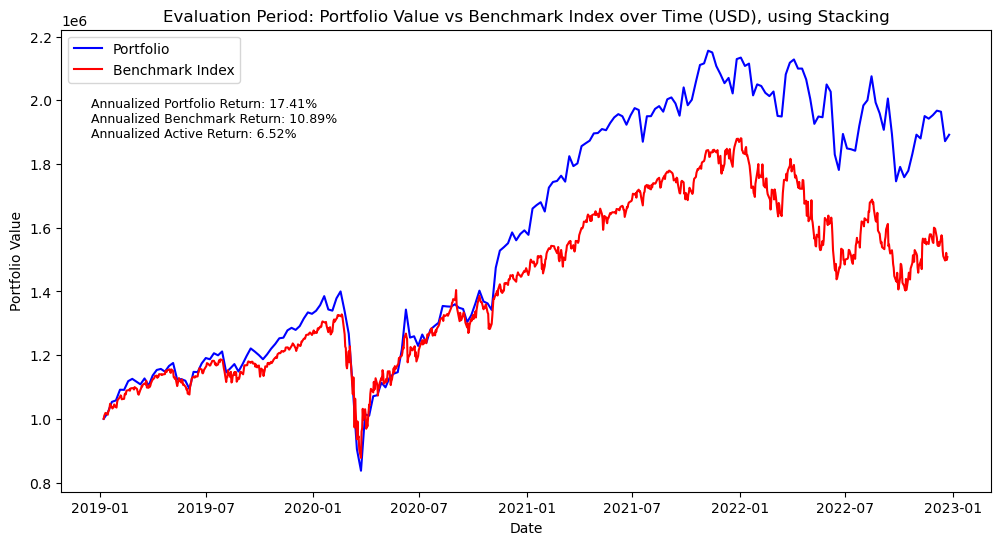

In [681]:
#plot both make big plot
plt.figure(figsize=(12,6))
plt.plot(portfolio_value, label="Portfolio", color="blue")
plt.plot(bm_index_prices_test_period.Date, bm_index_prices_test_period.Price, label="Benchmark Index", color="red")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plot_title = "Portfolio Value vs Benchmark Index over Time (USD)"
if eval_dataset_mode:
    plot_title = "Evaluation Period: " + plot_title
    plot_file_path = f"{DATA_DIR}/{BM_NAME}_plot_eval_{optimum_model_name}_port_vs_bm.png"
else:
    plot_title = "Test Period: " + plot_title
    plot_file_path = f"{DATA_DIR}/{BM_NAME}_plot_test_{optimum_model_name}_port_vs_bm.png"
plot_title += ", using " + optimum_model_name
plt.title(plot_title)
#print annualized port and bm and active returns, small font
plt.text(0.15, 0.75, f"Annualized Portfolio Return: {annualized_port_return:.2%}", fontsize=9, transform=plt.gcf().transFigure)
plt.text(0.15, 0.725, f"Annualized Benchmark Return: {annualized_bm_return:.2%}", fontsize=9, transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, f"Annualized Active Return: {annualized_active_return:.2%}", fontsize=9, transform=plt.gcf().transFigure)
plt.legend(loc="upper left")
plt.savefig(plot_file_path)
plt.show()